# Modelling and Evaluation Notebook

## Objectives 

* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves/test
* inputs/cherry-leaves/validation
* inputs/cherry-leaves/train
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

## Import regular packages

In [89]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set up working directory

In [90]:
cwd= os.getcwd()

In [91]:
os.chdir('/workspace/cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [92]:
work_dir = os.getcwd()
work_dir

'/workspace/cherry-leaves'

---

## Setup input directory

Set train, validation and test paths.

In [93]:
my_data_dir = '/workspace/cherry-leaves/inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setup output directory

In [94]:
version = '4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set labels

In [95]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

In [96]:
## Import saved image shape embedding
import joblib
version = '1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Explore the numbers of images in the validation, train and test datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




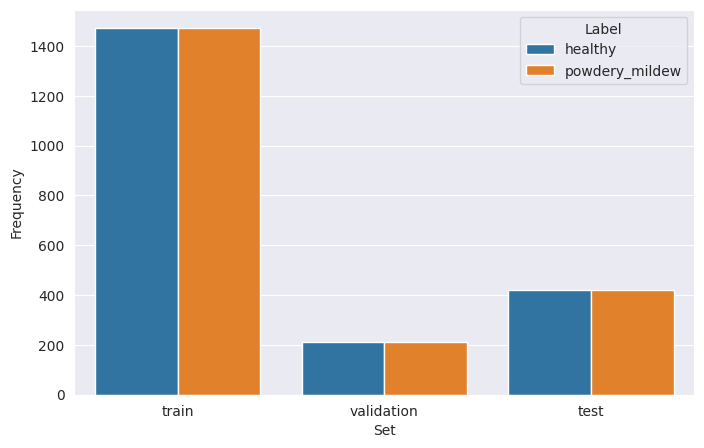

In [97]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

In [104]:
import numpy as np
np.object = object  
np.bool = bool
np.int = int

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#### Initialize ImageDataGenerator

In [105]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

#### Augment training image dataset

In [106]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment validation image dataset

In [107]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment test image dataset

In [108]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot augmented training image

(20, 256, 256, 3)


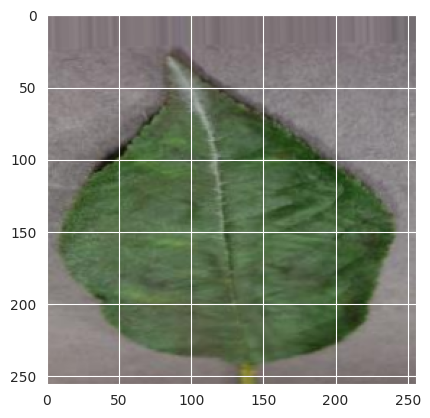

(20, 256, 256, 3)


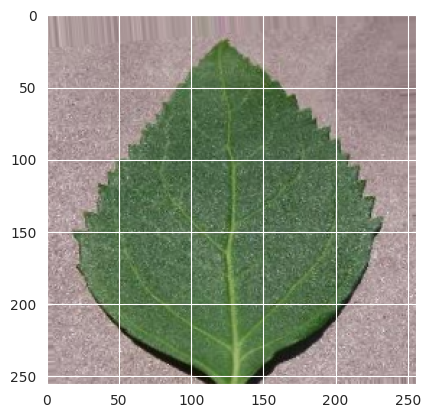

(20, 256, 256, 3)


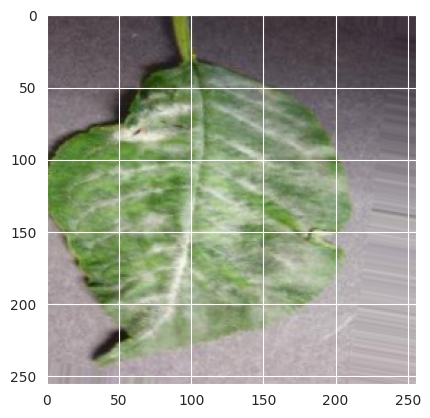

In [109]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation and test images

(20, 256, 256, 3)


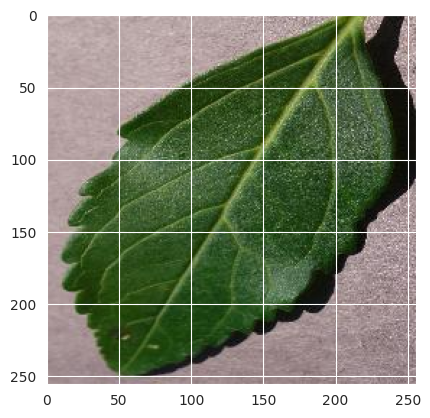

(20, 256, 256, 3)


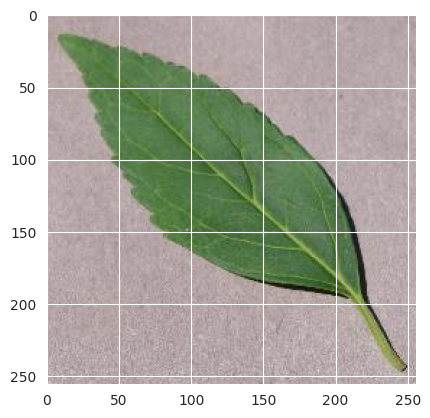

(20, 256, 256, 3)


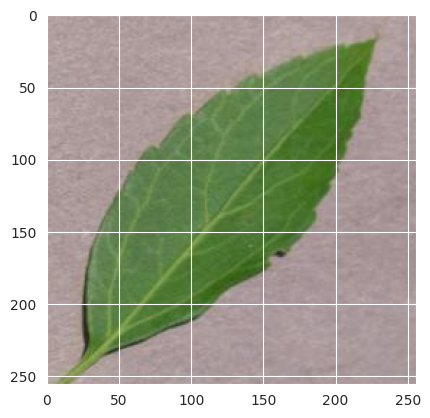

In [110]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


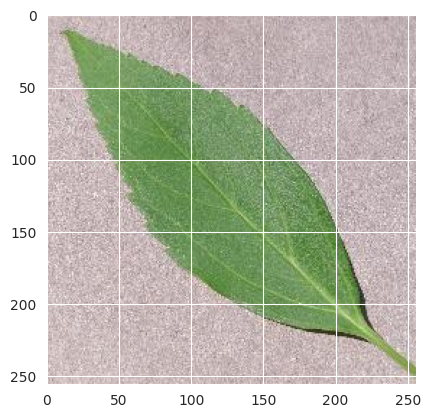

(20, 256, 256, 3)


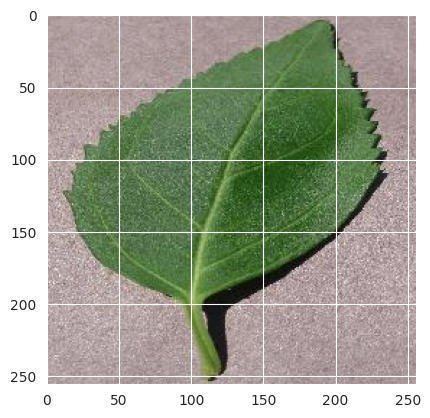

(20, 256, 256, 3)


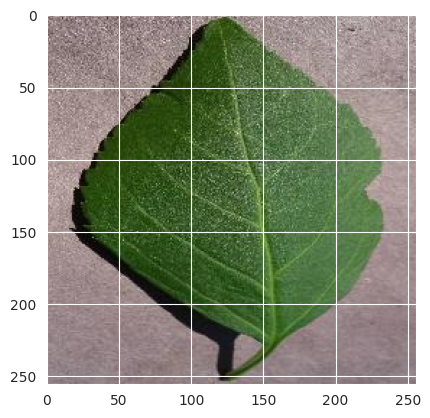

In [111]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Save class_indices

In [112]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/4/class_indices.pkl']

---

### Create ML model

---

#### Import packages 

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

#### Model

In [114]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model Summary

In [115]:
create_tf_model().summary()

2024-01-06 00:51:13.463095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-06 00:51:13.463129: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-06 00:51:13.463149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (renwarp-cherryleaves-qplnpx56pvo): /proc/driver/nvidia/version does not exist
2024-01-06 00:51:13.463681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

#### Early stopping

In [116]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#### Fit model for training

In [117]:
model = create_tf_model()
model.fit(train_set,
          epochs=30,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-01-06 00:51:25.074378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
147/147 [==============================] - 144s 972ms/step - loss: 0.3693 - accuracy: 0.8276 - val_loss: 0.0351 - val_accuracy: 0.9929
Epoch 2/30
147/147 [==============================] - 139s 948ms/step - loss: 0.0806 - accuracy: 0.9733 - val_loss: 0.2003 - val_accuracy: 0.9167
Epoch 3/30
147/147 [==============================] - 138s 941ms/step - loss: 0.0450 - accuracy: 0.9836 - val_loss: 0.0933 - val_accuracy: 0.9595
Epoch 4/30
147/147 [==============================] - 137s 933ms/step - loss: 0.0336 - accuracy: 0.9901 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 5/30
147/147 [==============================] - 138s 936ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0117 - val_accuracy: 0.9976
Epoch 6/30
147/147 [==============================] - 139s 947ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.0289 - val_accuracy: 0.9952
Epoch 7/30
147/147 [==============================] - 136s 927ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.0115 -

#### Save model

In [118]:
model.save('outputs/4/cherry-leaves-model-h1')

2024-01-06 01:17:08.820427: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: outputs/4/cherry-leaves-model-h1/assets


---

## Model Performance

---

#### Model learning curve

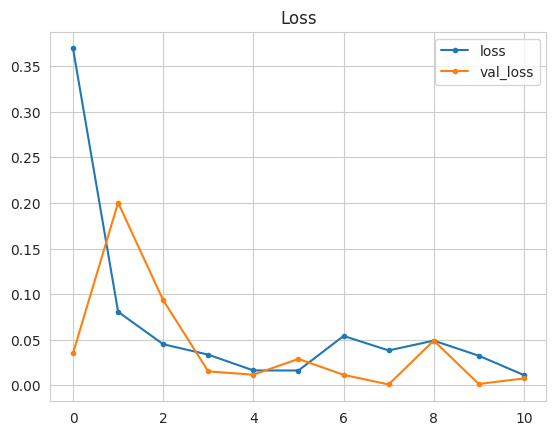

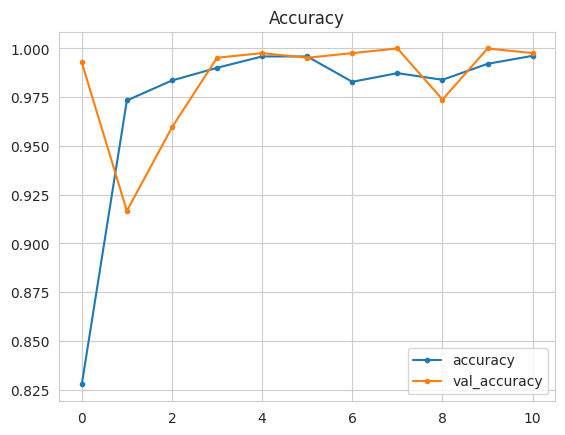

In [119]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

Load the saved model

In [120]:
from keras.models import load_model
model = load_model('outputs/4/cherry-leaves-model-h1')

Evaluate the model on test set

In [121]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 9s 213ms/step - loss: 0.0102 - accuracy: 0.9976


### Save evaluation pickle

In [122]:
joblib.dump(value=evaluation,
            filename=f"outputs/4/evaluation.pkl")

['outputs/4/evaluation.pkl']

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


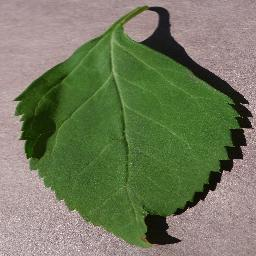

In [123]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [124]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [125]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999999988606346
healthy


---

# Conclusion

---

* **Model Performance**: During the implementation of this notebook the ML model ran its "Fit model for training" step 9 times. Increasing its accuracy during the first 3 runs. Then it settled down. It was clear that the ML model had reached the desired result of 97% accuracy.
* **Future Improvements**: For future improvements the dataset could be expanded. The ML model can be tested on a more diverse dataset and hyperparameters can be refined. 

## Push files to Repo

* .gitignore

In [126]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
cherry-leaves/inputs/cherry-leaves/test/
cherry-leaves/inputs/cherry-leaves/train/

* Git status

In [127]:
!git status

On branch gitpod
Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    inputs/cherry-leaves/validation/healthy/002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9655.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_flipTB.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/00a8e886-d172-4261-85e2-780b3c50ad4d___JR_HL 4156.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/02818f40-58e6-4c7d-bfbc-372d89b2045b___JR_HL 4259.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/02a7466b-4847-4a18-bbd9-f0278e7b8d20___JR_HL 9582.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/036b575a-cbe7-45a4-8b97-15b7ecdf3dee___JR_HL 9600_flipTB.JPG
	deleted:    inputs/cherry-leaves/validation/healthy/

### Creating a new branch and switch to it

In [129]:
!git checkout -b gitpod-v2


Switched to a new branch 'gitpod-v2'


* Git add

In [130]:
!git add .

* Git commit

In [131]:
!git commit -m " Add new ML model with Gitpod"

[gitpod-v2 81a45c1]  Add new ML model with Gitpod
 4199 files changed, 5370 insertions(+), 4499 deletions(-)
 rename inputs/cherry-leaves/{validation => test}/healthy/002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9655.JPG (100%)
 create mode 100644 inputs/cherry-leaves/test/healthy/0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9765_180deg.JPG
 rename inputs/cherry-leaves/{validation => test}/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_flipTB.JPG (100%)
 create mode 100644 inputs/cherry-leaves/test/healthy/04189592-5db7-441e-a831-eaaa2d7f5d21___JR_HL 9867_flipTB.JPG
 create mode 100644 inputs/cherry-leaves/test/healthy/048daa26-d38c-477a-96b8-018b3d4ba386___JR_HL 9767_flipTB.JPG
 create mode 100644 inputs/cherry-leaves/test/healthy/050b598c-9105-4838-8996-101568d6941e___JR_HL 9732_180deg.JPG
 create mode 100644 inputs/cherry-leaves/test/healthy/069996a8-8cdb-4837-a5fe-c5a957b5677a___JR_HL 3938_flipTB.JPG
 create mode 100644 inputs/cherry-leaves/test/healthy/085e9f8b-9574-4b6

* Git Push

In [132]:
!git push origin gitpod-v2

Enumerating objects: 3834, done.
Counting objects: 100% (3834/3834), done.
Delta compression using up to 16 threads
Compressing objects: 100% (3820/3820), done.
Writing objects: 100% (3824/3824), 125.06 MiB | 16.90 MiB/s, done.
Total 3824 (delta 3), reused 3790 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/4/cherry-leaves-model-h1/variables/variables.data-00000-of-00001 is 85.03 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: 
remote: Create a pull request for 'gitpod-v2' on GitHub by visiting:
remote:      https://github.com/Renwar-P/cherry-leaves/pull/new/gitpod-v2
remote: 
To https://github.com/Renwar-P/cherry-leaves.git
 * [new branch]      gitpod-v2 -> gitpod-v2
